In [27]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import Counter
import sys

sys.path.append(r"S:\Samdroid\Notebook\School\CS6120\TwitterFood2\TwitterFood\model_code")
from gensim.models import KeyedVectors
from CNN import TextCNN, pad_features


In [28]:
#import TweetsByFood.csv
#import everything needed to run the below function 
#The textCNN is in ../model_code/CNN.py
#pad features is also in ../model_code/CNN.py
#tokenize_input is in ../model_code/CNN.py
def tokenize_input(word2vec_path, input_texts):
    """
    Purpose: prep text inputs for inference
    Args:
        word2vec_path: path to word2vec model with embeddings
        input_texts: list of texts to classify

    Returns:
        tokenized_inputs: list of tokenized inputs (each as a list of embedding indices)
        embed_lookup: the embedding lookup model
    """
    from gensim.models import KeyedVectors

    # Load Word2Vec embeddings
    embed_lookup = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)

    tokenized_inputs = []
    for input_text in input_texts:
        input_text = input_text.lower()
        input_words = input_text.split()

        tokenized_input = []
        for word in input_words:
            idx = embed_lookup.key_to_index.get(word, 0)
            tokenized_input.append(idx)

        tokenized_inputs.append(tokenized_input)

    return tokenized_inputs, embed_lookup


def run_text_word_embedding_infer(
    net_path, input_texts, word2vec_path, dropout=0.5
):
    """
    Purpose: classify given text inputs
    Args:
        net_path: path to trained model pth file
        input_texts: list of texts to classify
        word2vec_path: path to trained word embeddings
        Returns: list of classifications for input texts
    """
    embed_lookup = None

    mappings, embed_lookup = tokenize_input(word2vec_path, input_texts)

    net = TextCNN(
        embed_model=embed_lookup,
        embedding_dim=200,
        vocab_size=len(embed_lookup.key_to_index),
        num_filters=100,
        num_classes=1,
        dropout=dropout,
        kernel_sizes=[3, 4, 5]
    )
    checkpoint = torch.load(net_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.eval()

    seq_length = 200
    features = pad_features(mappings, seq_length)
    feature_tensor = torch.from_numpy(features)

    outputs = net(feature_tensor)
    preds = torch.round(outputs.squeeze())

    mapping_dict = {
        0: 'negative',
        1: 'positive'
    }
    classifications = [mapping_dict[pred.item()] for pred in preds]
    return classifications


In [29]:
#call this function with the input texts being retrieved from the TweetsByFood.csv file ['preprocessed_tweets']
#net path is ../Intermediate/SomeStuff/word_embedding_model_checkpoint.pth
#word2vec_path is ../Intermediate\\word2vec_200_cbow.model
#drop all the rows where the inference is 0
#save to a new csv file called 'positive_tweets.csv'
#read the food_words.csv which is really a list of words
#create a huge hash table of the counts of the words in the 'positive_tweets.csv' file that are in the food_words.csv file
#graph the top 10 of the hash table in a bar graph

# Load data
tweets_df = pd.read_csv('filtered_tweets.csv')
input_texts = tweets_df['preprocessed_tweets'].tolist()
# Run inference
net_path = '../Intermediate/SomeStuff/2/word_embedding_model_checkpoint.pth'
word2vec_path = '../Intermediate\\word2vec_200_cbow.model'
def batch_process(input_texts, batch_size, net_path, word2vec_path):
    predictions = []
    for i in range(0, len(input_texts), batch_size):
        batch = input_texts[i:i + batch_size]
        batch_predictions = run_text_word_embedding_infer(net_path, batch, word2vec_path)
        predictions.extend(batch_predictions)
    return predictions

# Example usage
batch_size = 10000
predictions = batch_process(input_texts, batch_size, net_path, word2vec_path)



[('coffee', 4445), ('ice', 2322), ('tea', 2247), ('chocolate', 2121), ('cream', 2030), ('beer', 1914), ('cake', 1861), ('wine', 1554), ('water', 1551), ('bbq', 1539)]


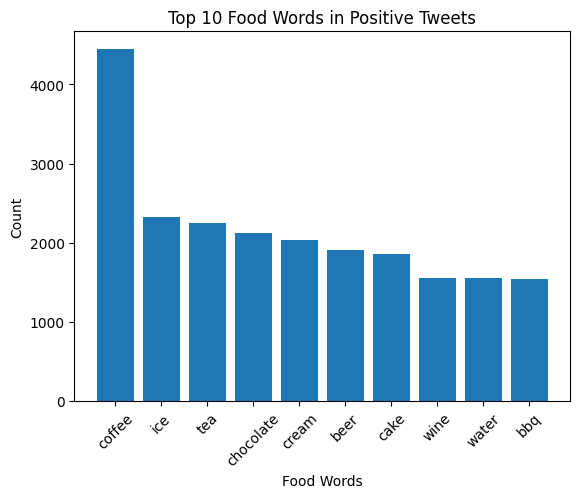

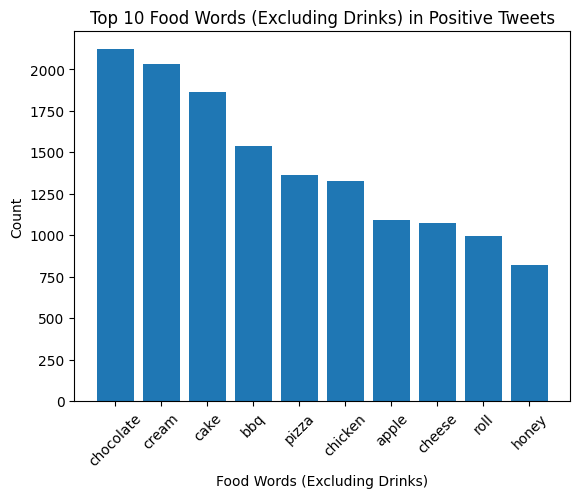

In [30]:
# Filter positive tweets
tweets_df = pd.read_csv('filtered_tweets.csv')
tweets_df['predictions'] = predictions
positive_tweets_df = tweets_df[tweets_df['predictions'] == 'positive']
positive_tweets_df.to_csv('positive_tweets.csv', index=False)

# Analyze food-related words
food_words = pd.read_csv('food_words.csv')['words'].tolist()
positive_tweets_text = ' '.join(positive_tweets_df['preprocessed_tweets'].tolist())
word_counts = Counter(word for word in positive_tweets_text.split() if word in food_words)

# Plot top 10 food words
top_food_words = word_counts.most_common(10)
print(top_food_words)
words, counts = zip(*top_food_words)

plt.bar(words, counts)
plt.xlabel('Food Words')
plt.ylabel('Count')
plt.title('Top 10 Food Words in Positive Tweets')
plt.xticks(rotation=45)
plt.show()

drinks_list = pd.read_csv('drinks.csv')['drink'].str.lower().tolist()

filtered_word_counts = {word: count for word, count in word_counts.items() if word not in drinks_list}
filtered_word_counts = Counter(filtered_word_counts)

top_food_words_filtered = filtered_word_counts.most_common(10)
words_filtered, counts_filtered = zip(*top_food_words_filtered)

plt.bar(words_filtered, counts_filtered)
plt.xlabel('Food Words (Excluding Drinks)')
plt.ylabel('Count')
plt.title('Top 10 Food Words (Excluding Drinks) in Positive Tweets')
plt.xticks(rotation=45)
plt.show()
